In [1]:
import gym
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline

In [44]:
class Agent():
    def __init__(self, learning_rate):
        self.learning_rate = learning_rate
        self.sess = tf.InteractiveSession()
        self.s = tf.placeholder(tf.float32, [None, 4], name='s')
        self.a = tf.placeholder(tf.int32, [None], name='a')
        self.r = tf.placeholder(tf.float32, [None], name='r')
         
        self.W = tf.Variable(tf.random_normal([4, 2]), name='W')
        self.output = tf.nn.softmax(tf.matmul(self.s, self.W)) # simple linear policy
        one_hot = tf.one_hot(self.a, 2)
        o = tf.reduce_sum(self.output * one_hot, axis=1)
        self.loss = -tf.reduce_sum(tf.log(o) * self.r)
        
        Wg = tf.gradients(self.loss, [self.W])[0]
        solver = tf.train.AdamOptimizer(learning_rate=self.learning_rate)
        self.update = solver.apply_gradients([(Wg, self.W)])
        
    def train(self, s, a, r):
        self.sess.run(self.update, {self.s: s, self.a: a, self.r: r})
        
    def decide(self, s):
        o = self.sess.run(self.output, {self.s: [s]})[0]
        return 0 if np.random.random() <= o[0] else 1 # probabilistic policy

In [45]:
gamma = 0.95
n_episodes = 200
train_every = 5
tf.reset_default_graph()
agent = Agent(learning_rate=0.2)
tf.global_variables_initializer().run()

s_all, a_all, r_all = [], [], []
nits = []
from gym import wrappers
env = gym.make('CartPole-v0')
env = wrappers.Monitor(env, '/home/ubuntu/gym_monitor', force=True)
for ei in range(n_episodes):
    s_arr, a_arr, r_arr = [], [], []
    s = env.reset()
    nit = 0
    done = False
    while not done:
        env.render()
        a = agent.decide(s)
        s1, r, done, _ = env.step(a)
        nit += 1
        s_arr.append(s)
        a_arr.append(int(a))
        r_arr.append(r)
        s = s1
    nits.append(nit)
    if ei % 100 == 0:
        print("Episode {} ran for {} steps".format(ei, np.mean(nits[-100:])))
    
    for i in reversed(range(nit)):
        if i + 1 < nit:
            r_arr[i] += gamma * r_arr[i+1]
    
    r_arr = list((r_arr - np.mean(r_arr)) / np.std(r_arr))
    if nit >= 200:
        r_arr = [1.0] * len(r_arr)
    nit = 0
    
    s_all += s_arr
    a_all += a_arr
    r_all += r_arr
        
    if ei > 0 and ei % train_every == 0:   
        agent.train(s_all, a_all, r_all)
        s_all, a_all, r_all = [], [], []
        
env.close()

[2017-09-03 03:01:34,841] Making new env: CartPole-v0
[2017-09-03 03:01:34,844] Clearing 14 monitor files from previous run (because force=True was provided)
[2017-09-03 03:01:34,846] Starting new video recorder writing to /home/ubuntu/gym_monitor/openaigym.video.11.9406.video000000.mp4
[2017-09-03 03:01:35,382] Starting new video recorder writing to /home/ubuntu/gym_monitor/openaigym.video.11.9406.video000001.mp4


Episode 0 ran for 34.0 steps


[2017-09-03 03:01:36,101] Starting new video recorder writing to /home/ubuntu/gym_monitor/openaigym.video.11.9406.video000008.mp4
[2017-09-03 03:01:38,644] Starting new video recorder writing to /home/ubuntu/gym_monitor/openaigym.video.11.9406.video000027.mp4
[2017-09-03 03:01:44,448] Starting new video recorder writing to /home/ubuntu/gym_monitor/openaigym.video.11.9406.video000064.mp4


Episode 100 ran for 101.74 steps


[2017-09-03 03:02:07,812] Starting new video recorder writing to /home/ubuntu/gym_monitor/openaigym.video.11.9406.video000125.mp4
[2017-09-03 03:02:39,853] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/gym_monitor')


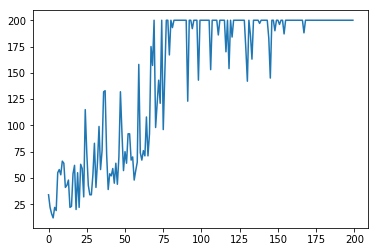

In [46]:
plt.plot(nits)

In [41]:
gym.upload('/home/ubuntu/gym_monitor', api_key='sk_f83vlfx1Ree3oFRhEbGxg')

[2017-09-03 02:55:53,345] [CartPole-v0] Uploading 200 episodes of training data
[2017-09-03 02:55:53,452] [CartPole-v0] Uploading videos of 6 training episodes (45124 bytes)
[2017-09-03 02:55:53,506] [CartPole-v0] Creating evaluation object from /home/ubuntu/gym_monitor with learning curve and training video
[2017-09-03 02:55:53,616] 
****************************************************
You successfully uploaded your evaluation on CartPole-v0 to
OpenAI Gym! You can find it at:

    https://gym.openai.com/evaluations/eval_0ZgCz7UGQHzdGkTWaJrXA

****************************************************


In [9]:
import gym
import numpy as np
import tensorflow as tf
import tensorflow.contrib.layers as layers

from gym import wrappers


def discounted_reward(rewards, gamma):
    """Compute the discounted reward."""
    ans = np.zeros_like(rewards)
    running_sum = 0
    # compute the result backward
    for i in reversed(range(len(rewards))):
        running_sum = running_sum * gamma + rewards[i]
        ans[i] = running_sum
    return ans


def test():
    """Just a test function to make sure I'm coding the
    right thing. """
    rewards = np.array([4, 2, 2, 1])
    print(discounted_reward(rewards, 1))
    # print out some help information about the environment
    env = gym.make('CartPole-v0')
    s = env.reset()
    print('Start state: ', s)
    print('Action space: ', env.action_space.n)


class Agent(object):
    def __init__(self, input_size=4, hidden_size=2, gamma=0.95,
                 action_size=2, alpha=0.1):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.gamma = gamma
        self.action_size = action_size
        self.alpha = alpha
        # save the hyper parameters
        self.params = self.__dict__.copy()
        # placeholders
        self.input_pl = tf.placeholder(tf.float32, [None, input_size])
        self.action_pl = tf.placeholder(tf.int32, [None])
        self.reward_pl = tf.placeholder(tf.float32, [None])
        # a two-layer fully connected network
        hidden_layer = layers.fully_connected(self.input_pl,
                                              hidden_size,
                                              biases_initializer=None,
                                              activation_fn=tf.nn.relu)
        self.output = layers.fully_connected(hidden_layer,
                                             action_size,
                                             biases_initializer=None,
                                             activation_fn=tf.nn.softmax)
        # responsible output
        one_hot = tf.one_hot(self.action_pl, action_size)
        responsible_output = tf.reduce_sum(self.output * one_hot, axis=1)
        self.loss = -tf.reduce_mean(tf.log(responsible_output) * self.reward_pl)
        # training variables
        variables = tf.trainable_variables()
        self.variable_pls = []
        for i, var in enumerate(variables):
            self.variable_pls.append(tf.placeholder(tf.float32))
        self.gradients = tf.gradients(self.loss, variables)
        solver = tf.train.AdamOptimizer(learning_rate=alpha)
        self.update = solver.apply_gradients(zip(self.variable_pls, variables))

    def next_action(self, sess, feed_dict, greedy=False):
        """Pick an action based on the current state.
        Args:
        - sess: a tensorflow session
        - feed_dict: parameter for sess.run()
        - greedy: boolean, whether to take action greedily
        Return:
            Integer, action to be taken.
        """
        ans = sess.run(self.output, feed_dict=feed_dict)[0]
        if greedy:
            return ans.argmax()
        else:
            return np.random.choice(range(self.action_size), p=ans)

    def show_parameters(self):
        """Helper function to show the hyper parameters."""
        for key, value in self.params.items():
            print(key, '=', value)


render = False
update_every = 3
print_every = 50
n_episodes = 1000
rate = 0.01
running_reward = 0.0
tf.reset_default_graph()
agent = Agent(hidden_size=10, alpha=1e-1, gamma=0.95)
agent.show_parameters()
env = gym.make('CartPole-v0')
#env = wrappers.Monitor(env, 'tmp/trial/', force=True)
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    grad_buffer = sess.run(tf.trainable_variables())
    for idx in range(len(grad_buffer)):
        grad_buffer[idx] *= 0
    for i in range(n_episodes):
        s = env.reset()
        state_history = []
        reward_history = []
        action_history = []
        current_reward = 0
        while True:
            feed_dict = {agent.input_pl: [s]}
            greedy = False
            action = agent.next_action(sess, feed_dict, greedy=greedy)
            snext, r, done, _ = env.step(action)
            if render and i % 50 == 0:
                env.render()
            current_reward += r
            state_history.append(s)
            reward_history.append(r)
            action_history.append(action)
            s = snext
            if done:
                state_history = np.array(state_history)
                rewards = discounted_reward(reward_history, agent.gamma)
                R = rewards
                # normalizing the reward really helps
                rewards = (rewards - np.mean(rewards)) / np.std(rewards)
                feed_dict = {
                    agent.reward_pl: rewards,
                    agent.action_pl: action_history,
                    agent.input_pl: state_history
                }
                episode_gradients = sess.run(agent.gradients,
                                             feed_dict=feed_dict)
                #print("updating ep gradient")
                for idx, grad in enumerate(episode_gradients):
                    grad_buffer[idx] += grad

                if i % update_every == 0:
                    #print('updating')
                    feed_dict = dict(zip(agent.variable_pls, grad_buffer))
                    sess.run(agent.update, feed_dict=feed_dict)
                    # reset the buffer to zero
                    for idx in range(len(grad_buffer)):
                        grad_buffer[idx] *= 0
                if i % print_every == 0:
                    print('episode %d, current_reward %d, running_reward %d' % (i, current_reward, running_reward))
                break
        running_reward = rate * current_reward + (1 - rate) * running_reward


#if __name__ == '__main__':
#    test()
#train()

[2017-09-03 02:24:45,279] Making new env: CartPole-v0


input_size = 4
hidden_size = 10
gamma = 0.95
action_size = 2
alpha = 0.1
episode 0, current_reward 12, running_reward 0
episode 50, current_reward 200, running_reward 26
episode 100, current_reward 200, running_reward 84
episode 150, current_reward 200, running_reward 130
episode 200, current_reward 200, running_reward 157
episode 250, current_reward 200, running_reward 162
episode 300, current_reward 180, running_reward 165
episode 350, current_reward 195, running_reward 164
episode 400, current_reward 200, running_reward 166
episode 450, current_reward 200, running_reward 179
episode 500, current_reward 200, running_reward 187
episode 550, current_reward 200, running_reward 192
episode 600, current_reward 200, running_reward 195
episode 650, current_reward 200, running_reward 197
episode 700, current_reward 200, running_reward 198
episode 750, current_reward 200, running_reward 196
episode 800, current_reward 200, running_reward 193
episode 850, current_reward 200, running_reward 196

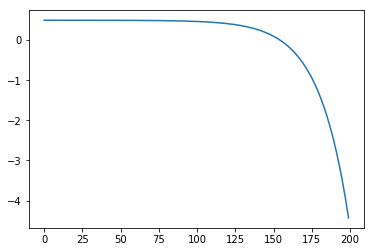

In [10]:
plt.plot(rewards)